In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from make_map import make_map

from file_util import load_matlab_data
from channel_overlap import channel_overlap
from plot import plot_discharge
from metrics import *


import cPickle as pickle

In [2]:
TH_TOPO = -0.5
TH_ANGLE = 75
TH_VEL = 0.3 # use the threshold value for mud deposition (U_dep_mud)

fbase = 'baseF25data'
froot = '../JGR2016_data/'
sroot = 'mapfiles/'

In [4]:
for fnum in range(4005,4006):

    fname = fbase + str(fnum)
    data = load_matlab_data(froot, fname)

    topo = data['eta']
    uw = data['uw']

    # clip to make the file smaller
    topo_clip = topo[3:-5,5:-10]
    vel_clip = uw[3:-5,5:-10]

    mapfile = make_map(topo_clip,
                       vel_clip,
                       topo_threshold = TH_TOPO,
                       angle_threshold = TH_ANGLE,
                       velocity_threshold = TH_VEL,
                       numviews = 5,
                       save_file = False,
                       sroot = sroot,
                       fname = fname)

    area = fractional_areas(mapfile)
    EdgeDistMap, histogram = nearest_edge_distance(mapfile)
    D_frac = fractal_dimension(mapfile['centerlinemap'])

In [5]:
filenames = [sroot + fbase + str(i) + '.p' for i in range(4005,4010)]
overlapmap, difference, phi, O_phi = channel_overlap(filenames)

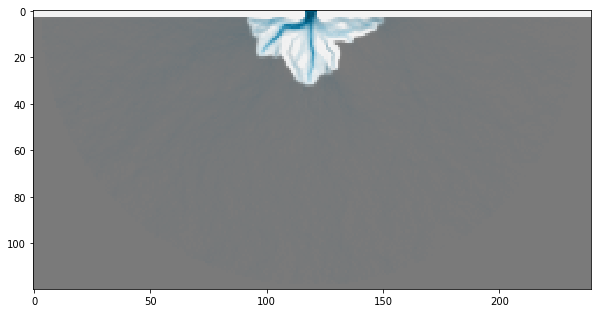

In [6]:
fname = fbase + str(4006)
data = load_matlab_data(froot, fname)

plot_discharge(data)